In [1]:
import jax
from jax import numpy as jnp
from jax.config import config; config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import sys; sys.path.insert(1, '..')

from algs.train import PG_Trainer, TracePlotter
from env.utils import ExampleMDPs
from env.gridworld import gridplot

### Example training with oracle access to the gradients

In [2]:
mdp = ExampleMDPs.gworld1()
trainer = PG_Trainer(mdp,policy_lr=2,beta=0.01,max_theta=1e3)
optimizers, trace = trainer.train(60)

100%|██████████| 60/60 [00:02<00:00, 21.06it/s]


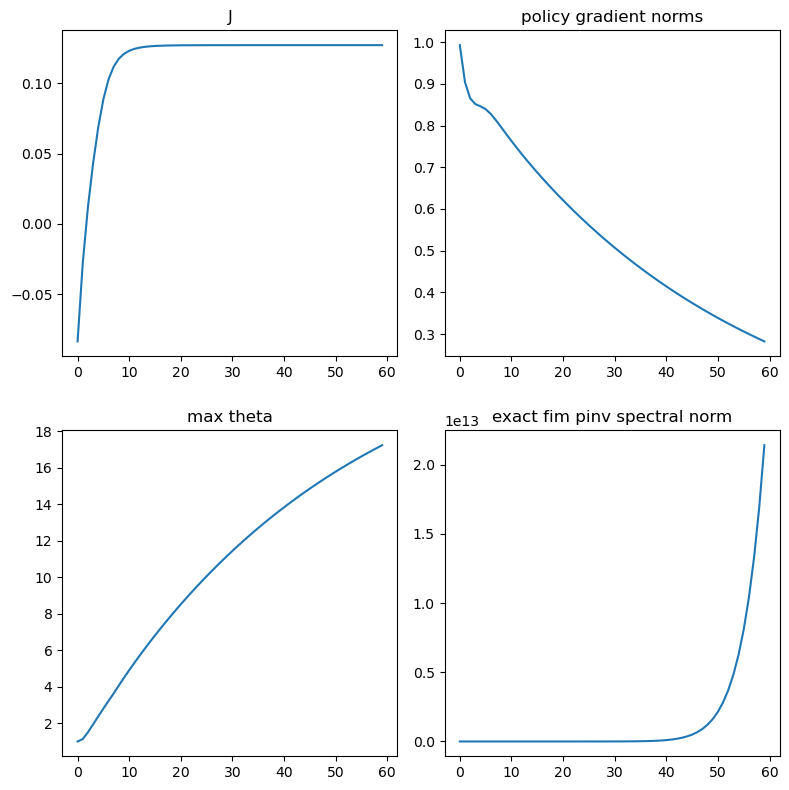

In [3]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
TracePlotter.plotScalar(ax[0,0],'J',trace)
TracePlotter.plotGradNorms(ax[0,1],'policy',trace)
tmaxs=jnp.array([jnp.max(e['params']['policy']) for e in trace])
ax[1,0].plot(tmaxs); ax[1,0].set_title('max theta')
TracePlotter.plotGradNorms(ax[1,1],'exact_fim_pinv',trace,'exact fim pinv spectral norm')
fig.tight_layout()
plt.show()

### Training with Monte-Carlo gradient estimators

In [4]:
mdp = ExampleMDPs.minimal1()
trainer = PG_Trainer(mdp,policy_lr=1,beta=0.1)
optimizers, trace = trainer.train(60)

100%|██████████| 60/60 [00:02<00:00, 24.08it/s]


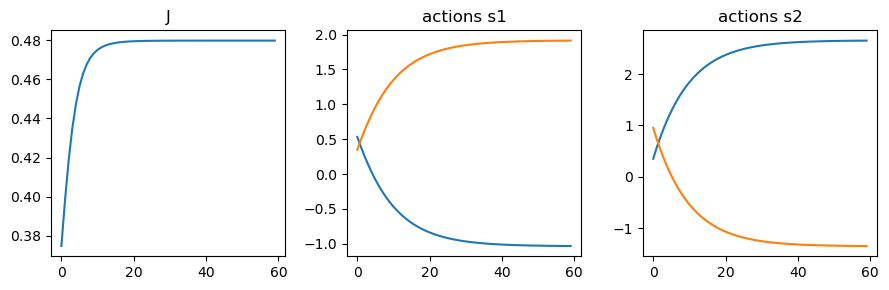

In [5]:
get_actions = lambda s : jnp.array([e['params']['policy'][s] for e in trace])
get_iter = lambda : jnp.array([e['iter'] for e in trace])
fig, ax = plt.subplots(1,3,figsize=(9,3))
TracePlotter.plotScalar(ax[0],'J',trace)
ax[1].plot(get_iter(),get_actions(0)[:,0]); ax[1].set_title('actions s1')
ax[1].plot(get_iter(),get_actions(0)[:,1])
ax[2].plot(get_iter(),get_actions(1)[:,0]); ax[2].set_title('actions s2')
ax[2].plot(get_iter(),get_actions(1)[:,1])
fig.tight_layout()

In [21]:
from env.sample import Sampler
from algs.pg import stochNaturalPG

mdp = ExampleMDPs.minimal1()
smp = Sampler(mdp,batchsize=400,horizon=100)
trainer = PG_Trainer(mdp,policy_lr=0.001,beta=0.1,sampler=smp,gradients=stochNaturalPG,max_theta=3e2,key=jax.random.PRNGKey(1312))
optimizers, trace = trainer.train(60)

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [01:07<00:00,  1.12s/it]


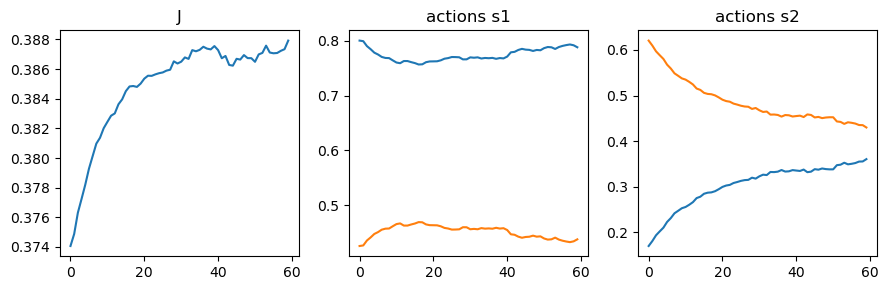

In [22]:
fig, ax = plt.subplots(1,3,figsize=(9,3))
TracePlotter.plotScalar(ax[0],'J',trace)
ax[1].plot(get_iter(),get_actions(0)[:,0]); ax[1].set_title('actions s1')
ax[1].plot(get_iter(),get_actions(0)[:,1])
ax[2].plot(get_iter(),get_actions(1)[:,0]); ax[2].set_title('actions s2')
ax[2].plot(get_iter(),get_actions(1)[:,1])
fig.tight_layout()

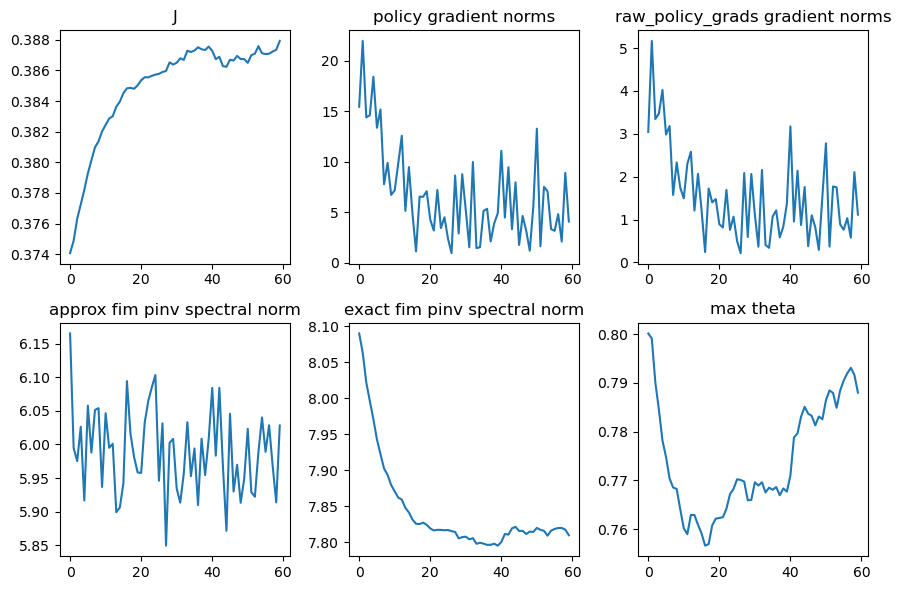

In [23]:
fig, ax = plt.subplots(2,3,figsize=(9,6))
TracePlotter.plotScalar(ax[0,0],'J',trace)
TracePlotter.plotGradNorms(ax[0,1],'policy',trace)
TracePlotter.plotGradNorms(ax[0,2],'raw_policy_grads',trace)
TracePlotter.plotGradNorms(ax[1,0],'fim_pinv',trace,'approx fim pinv spectral norm')
TracePlotter.plotGradNorms(ax[1,1],'exact_fim_pinv',trace,'exact fim pinv spectral norm')
tmaxs=jnp.array([jnp.max(e['params']['policy']) for e in trace])
ax[1,2].plot(tmaxs); ax[1,2].set_title('max theta')


# gridplot(mdp,ax[2],jnp.sum(mdp.R,axis=1),
            # stochastic_policy=trainer.pFun(trace[-1]['params']['policy']),
            # goals=mdp.goals)
fig.tight_layout()
plt.show()